# Rejection Sampling


We want to infer some properties of a density function that we can't 
sample directly from (which we'll call our target distribution $q$). However, we can evaluate this density function, ie. plug in an input and observe the output.
We want to transform observations from a proposal distribution $g$ 
(from which we can draw samples) into observations from our target 
distribution $q$.

## Set-up

[Text(0, 0.5, '$q(\\theta)$'), Text(0.5, 0, '$\\theta$')]

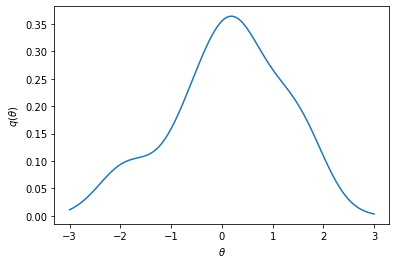

In [65]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def q_density(theta):
    r = np.array([ 1.1 ,  1.3 , -0.1 , -0.7 ,  0.2 , -0.4 ,  0.06, -1.7 ,
                   1.7 ,  0.3 ,  0.7 ,  1.6 , -2.06, -0.74,  0.2 ,  0.5 ])
    return stats.gaussian_kde(r, bw_method=0.48).evaluate(theta)

thetas = np.linspace(-3, 3, 100)
fig, ax = plt.subplots()
ax.plot(thetas, q_density(thetas))
ax.set(xlabel=r'$\theta$', ylabel=r'$q(\theta)$')

#### Choose a good proposal distribution

Think about what is a good proposal distribution for this? (You don't need to code it, we will give you something to start from in the answer)

#### Solution

We choose our proposal distribution to be the normal distribution 
$N(0,1.1)$. Usually, this choice is difficult, especially in higher
dimensions -- here, it is simpler (1D) and ... we are cheating.



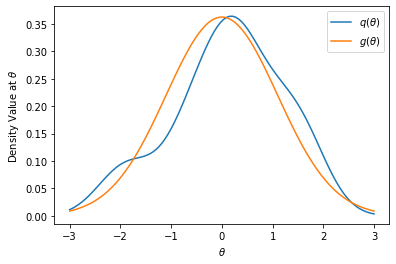

In [66]:
def g_density(theta):
    return stats.norm(0.0, 1.1).pdf(theta)

fig, ax = plt.subplots()
ax.plot(thetas, q_density(thetas), label=r'$q(\theta)$')
ax.plot(thetas, g_density(thetas), label=r'$g(\theta)$')
ax.set(xlabel=r'$\theta$', ylabel=r'Density Value at $\theta$')
ax.legend()

## The Rejection sampling itself

### Choose M



For rejection sampling we choose $M$ such that 
$M g(\theta) > q(\theta)$ for all $\theta$

How can we choose a suitable $M$ for this simple toy problem?

#### Solution

One naive way is to do this visually, which we can sort-of do for this simple toy problem.

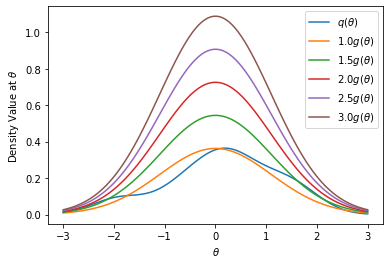

In [67]:
fig, ax = plt.subplots()
ax.plot(thetas, q_density(thetas), label=r'$q(\theta)$')
for M in [1., 1.5, 2.0, 2.5, 3.0]:
    ax.plot(thetas, M*g_density(thetas), label=f'${M}g(\\theta)$')
ax.set(xlabel=r'$\theta$', ylabel=r'Density Value at $\theta$')
ax.legend()

M = 2.5



We choose M=2.5 as it is the smallest sufficient.

Alternatively, we can do a parameter sweep!

In [68]:
theta_s = np.linspace(-3,3,100)
for M_proposal in np.linspace(0.5,4,10, endpoint=False):
  is_support = ~ np.any(q_density(theta_s) > M_proposal * g_density(theta_s))
  if is_support:
    print(M_proposal, is_support)
    break

M = M_proposal

1.9 True


### Sampling from the target


Sampling can be done with Scipy as:

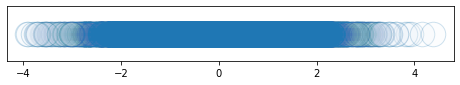

In [69]:
def sample_from_g(n_samples):
    return stats.norm(0.0, 1.1).rvs(n_samples)

g_samples = sample_from_g(10_000)

fig, ax = plt.subplots(figsize=(8, 1))
# Outline to improve visibility of faint points
ax.scatter(g_samples, np.ones_like(g_samples), s=600, alpha=0.2,
           c='white', edgecolor='#1f77b4')
ax.scatter(g_samples, np.ones_like(g_samples), s=600, alpha=0.01)
ax.tick_params(axis='y', left=False, labelleft=False)

And you can check that the samples are from the chosen distribution:

(array([  39.,  190.,  813., 1902., 2901., 2438., 1290.,  361.,   59.,
           7.]),
 array([-3.91474433, -3.08434092, -2.25393752, -1.42353412, -0.59313072,
         0.23727268,  1.06767608,  1.89807948,  2.72848289,  3.55888629,
         4.38928969]),
 <a list of 10 Patch objects>)

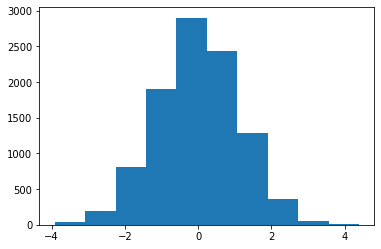

In [70]:
fig, ax = plt.subplots()
ax.hist(g_samples)

### Sampling from uniform

The next step in rejection sampling is to sample from the uniform distribution

In [71]:
uniform_samples = np.random.uniform(size=len(g_samples))

### Acceptance Probability

#### What is the acceptance probability?


#### Solution:

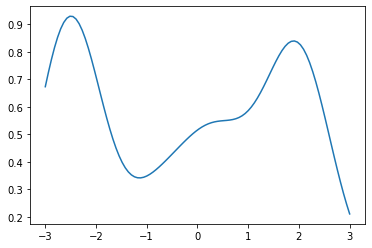

In [72]:
def acceptance_probability(theta):
    return q_density(theta) / (M*g_density(theta))

fig, ax = plt.subplots()
thetas = np.linspace(-3, 3, 100)
ax.plot(thetas, acceptance_probability(thetas))

#### Decide which uniform samples to keep.

#### Solution

In [73]:
def is_kept(uniform_samples, g_samples):
  return uniform_samples < acceptance_probability(g_samples)

to_keep = is_kept(uniform_samples, g_samples)

### What's next?

We can see how many samples are kept, and use them for further computations of interest, e.g., estimating the variance of the target distribution.

In [74]:
q_samples = g_samples[to_keep]
print(f'Original number of samples: {len(g_samples)}')
print(f'Number of accepted samples: {len(q_samples)}')

Original number of samples: 10000
Number of accepted samples: 5225




Try to approximate some function of moments via Monte Carlo and compute the variance of the estimate



Compute the expecttion of $f(x)$ for $x$ with density $q$.

$E[f(x)]=\int f(x) q(x) dx$

Do this for $f(x)=x^3$

In [75]:
Answer = np.mean(np.power(q_samples,3))
print(Answer)

-0.05366394556230788


### Sampling N samples via rejection sampling
Now combine the above steps into one function to sample N points as specified below.

#### Solution

In [76]:
def rejection_sampling(q_density, g_density, proposal_gen, N, M):
  """Function takes as inputs
  - q_density: the target density
  - g_density: the proposal density
  - proposal_gen: a function generating samples from an RV with density g_proposal
  - N: the number of samples to produce
  - M: the constant used to obtain an envelope of q_target.

  Output: N samples from q_target are sampled via rejection sampling, 
          and number of accepted and total samples"""

  accepted = 0
  total = 0
  samples = []

  while accepted < N:
    # generate N-accepted at a time, more efficient
    # could even take acceptance probability into account to overgenerate 
    # and reduce loop iterations even more
  
    prop = proposal_gen(N-accepted)
    uniform_samples = np.random.uniform(size=(N-accepted))
    # accept reject step
    samples_to_add = list(prop[uniform_samples < q_density(prop)/(M * g_density(prop))])
    # append accepted to samples and update couters
    samples += samples_to_add
    total += N-accepted
    accepted = len(samples)

  return samples, accepted, total

In [77]:
samples, accepted, total = rejection_sampling(q_density, g_density, sample_from_g, 10000, 2)

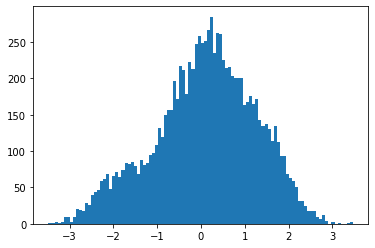

In [78]:
plt.hist(samples, bins=100)
plt.show()

### Acceptance Probability
In lectures you have seen how the acceptance probability of a point depends on the constant M. Verify this result empirically.

#### Solution

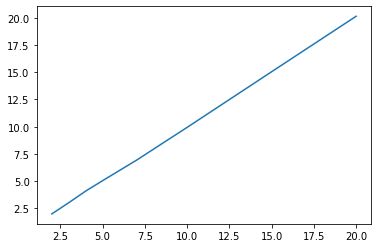

In [79]:
generated_per_accepted = []
M_list = [2,3,4,5,7,10,15,20]

for M in M_list:
  _, accepted, total = rejection_sampling(q_density, g_density, sample_from_g, 5000, M)
  generated_per_accepted.append(total/accepted)

plt.plot(M_list, generated_per_accepted)

## Importance Sampling

It can be challenging to find an efficient $g$ and $M$ such that $Mg(\theta) > q(\theta)$ for all $\theta$.
Since $Mg(\theta)$ will likely be quite different from $q(\theta)$, we'll end up rejecting a lot of points.

Furthermore, often we are interested in the estimation of functions of moments (eg. expectation). However, the direct estimators obtained as in the earlier sections may have high variance. Importance sampling can help to reduce the variance. Since some points may have a higher impact on the estimator we want to sample those more frequently to reduce the variance. This can be achieved by choosing a density which encourages sampling from those points. 

To ompute the expecttion of $f(x)$ for $X$ with density $q$ we can write:

$E_q[f(x)]=\int f(x) q(x) dx = \int f(x) \cfrac{q(x)}{g(x)} p(x) dx = E_g\left[f(x) \cfrac{q(x)}{g(x)}\right]$

So instead of sampling directly from $q(\cdot)$ we could sample from $g(\cdot)$ and then weight the points correpsondingly.

The ideal density g we could choose is such that
$$
g^*=\min _g \operatorname{var}_g\left(f(X) \frac{q(X)}{g(X)}\right)
$$
which can be shown to be proportional to:
$$
g^*(X) \propto |f(X)| g(X).
$$

So to conclude have the following estimator:
$\hat{E[f(x)]}=\cfrac{1}{N}\sum_N f(x^{i}) \cfrac{q(x^{i})}{g(x^{i})}$ where $x^i$ are samples from $g(\cdot)$

Do this for $f(x)=x^3$

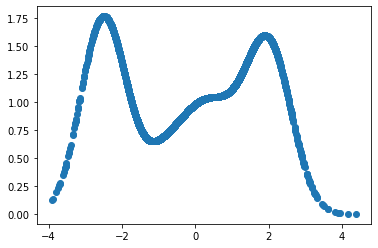

In [80]:
weights = q_density(g_samples)/g_density(g_samples)


fig, ax = plt.subplots()
ax.scatter(g_samples, weights)

In [81]:
Answer = np.mean(weights * np.power(g_samples,3))
print(Answer)

-0.05463209991296303


# Metropolis Hastings

In this question we consider the following density on $\mathbb{R}^2$
$$
f(x, y)=k \exp \left\{-\frac{x^2}{100}-\left(y+\frac{3}{100} x^2-3\right)^2\right\},
$$
where $k$ is a normalizing constant.

We want to design and implement a Metropolis Hastings algorithm to sample from this density.

# Plot the density
Lets first plot the unnormalized density (no need to compute the normalisation constant k).

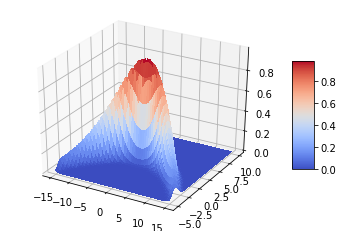

In [82]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# unnormalized density
def f_density(x,y):
  return np.exp(-x**2 / 100 - (y + 3/100 * x**2 - 3)**2)

# create grid
x_vec = np.linspace(-15,15,100)
y_vec = np.linspace(-5,10,100)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# evaluate on grid.
X, Y = np.meshgrid(x_vec, y_vec)
f_points = f_density(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, f_points, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## A simple Metropolis Hastings alogrithm

First implement a simple Metropolis Hastings algorithm with an additive random walk specified by a two dimensional Gaussian distribution (additive Gaussian noise centered at the current point of the chain). Note how the symmetry of the proposal density simplifies the acceptance ratio.

Additive random walk with Gaussian noise means that the porposal is

$N((x_{t-1}, y_{t-1}), \Sigma)$. Start simple with $\Sigma$ as the identity matrix.

Complete the function below.

Hint: Consider using the log exp trick
$$a/b = \exp( \log(a) - \log(b))$$

## Solution

In [83]:
# simple metropolis hastings
def MetrHastw(x0, sigmapropx, sigmapropy, nsteps, f):
  """
  Inputs:
  - x0: initial starting point
  - sigmapropx, sigmapropy: the standard deviations of the Gaussian distribution 
    used for the proposal for X and Y component respectively
  - nsteps: number of steps to take
  - f: the unnormalized density as defined above

  Outputs:
  - X: the chain produced by running this algorithm for nsteps steps
  """
  # initialize array to store samples
  X = np.zeros(shape = (2,nsteps+1))
  X[:,0] = x0
  
  # take steps
  for i in range(1,nsteps+1):
    # generate proposals
    x = np.random.normal(size=1,loc=X[0,(i-1)], scale=sigmapropx)
    y = np.random.normal(size=1,loc=X[1,(i-1)], scale=sigmapropy)

    # acceptance step
    uniform_sample = np.random.uniform(size=1)
    # using log exp trick for numeraically more stable
    acceptance_ratio = np.exp(np.log(f(x,y))-np.log(f(X[0,i-1], X[1,i-1])))

    if uniform_sample <= min(acceptance_ratio, 1):
       X[0,i] = x
       X[1,i] = y
    else: 
      X[:,i] = X[:,i-1]
  
  return X


In [90]:
samples = MetrHastw((0,0), sigmapropx=1, sigmapropy=1, nsteps=100000, f=f_density)

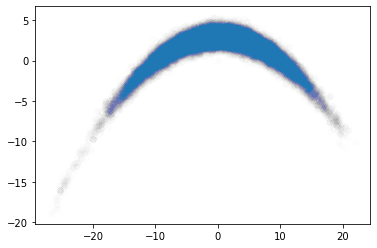

In [92]:
plt.scatter(samples[0,:], samples[1,:], alpha=0.005)
plt.show()

Not very balanced in the tails of the distribution, we might need to improve the proposal, or sample many more points...

## Improving the proposal

So far we have naively chosen $\Sigma$ as the identity matrix, but clearly $X$ and $Y$ are on very different scales so we should take this into account in our proposal. Furthermore, they could be correlated.

Adapt the proposal to take these two observations into account.

### Solution

In [86]:
# algorithm taking into account scale and dependency 
# by specifying the covariance matrix of the proposal

# simple metropolis hastings
def MetrHastw_cov(x0, sigmapropx, sigmapropy, nsteps, covariance, f):
  """
  Inputs:
  - x0: initial starting point
  - sigmapropx, sigmapropy: the standard deviations of the Gaussian distribution 
    used for the proposal for X and Y component respectively
  - nsteps: number of steps to take
  - f: the unnormalized density as defined above

  Outputs:
  - X: the chain produced by running this algorithm for nsteps steps
  """
  # initialize array to store samples
  X = np.zeros(shape = (2,nsteps+1))
  X[:,0] = x0
  Sigma = np.asarray([[sigmapropx**2, covariance],[covariance, sigmapropy**2]])

  # take steps
  for i in range(1,nsteps+1):
    # generate proposals
    prop = np.random.multivariate_normal(mean = X[:,i-1], cov = Sigma, size=1)
    x = prop[0,0]
    y = prop[0,1]
    # acceptance step
    uniform_sample = np.random.uniform(size=1)
    # using log exp trick for numeraically more stable
    acceptance_ratio = np.exp(np.log(f(x,y))-np.log(f(X[0,i-1], X[1,i-1])))

    if uniform_sample <= min(acceptance_ratio, 1):
       X[0,i] = x
       X[1,i] = y
    else: 
      X[:,i] = X[:,i-1]
  
  return X

In [87]:
chain = MetrHastw_cov((0,0), sigmapropx=4, sigmapropy=1.5, covariance=0.22, nsteps=100000, f=f_density)

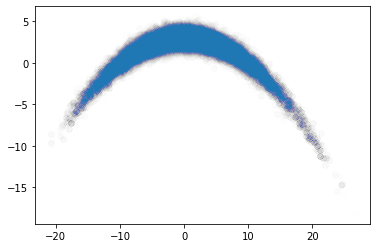

In [88]:
plt.scatter(chain[0,:], chain[1,:], alpha=0.005)
plt.show()

This looks more symmetric and balanced for more extreme x values

## Some Diagnostics for MCMC

Traceplots are one of the key diagnostics tools to check convergence and good mixing. What you want to see is no obvious trend in the traceplots.

It is also important to minimize the impact of the initial starting point. To do we discard the first M points of the chain. This is called burn-in.
You might also consider initializing several chains to understand the impact of the initial condition.

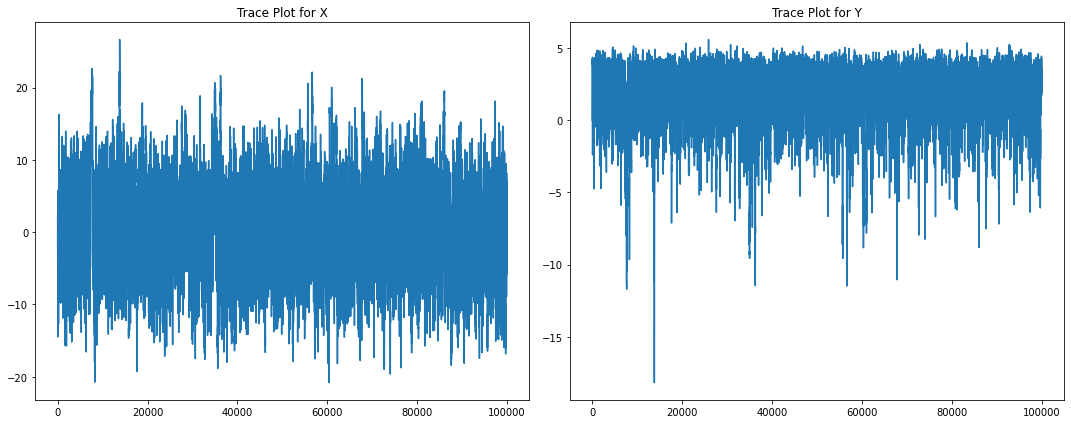

In [89]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(np.arange(chain.shape[1]),chain[0,:])
plt.title('Trace Plot for X')

plt.subplot(122)
plt.plot(np.arange(chain.shape[1]),chain[1,:])
plt.title('Trace Plot for Y')

plt.tight_layout()
plt.show()

You may also wnat to check the correlation between consecutive elements of the chain. To this end we can plot the autocorrelation.

In general the package pymc3 is very useful, if you don't have it installed run:
!pip install pymc3

(in the terminal without the '!')